# Background field design

In [1]:
%load_ext autoreload
%autoreload 2

import sympy as sym
import numpy as np
from pg_utils.pg_model import core, bg_fields
from pg_utils.sympy_supp import vector_calculus_3d as v3d
from scipy import special as specfun
from sympy.functions.special import spherical_harmonics as SH

---
## Configuring variables

In [8]:
from pg_utils.pg_model.core import r, theta, p, s, z, sph
xi = sym.Symbol(r'\xi', real=True)

In [9]:
r, t, p, s = sym.symbols(r'r, \theta, \phi, s', positive=True)
z = sym.Symbol('z', real=True)
xi = sym.Symbol(r'\xi', real=True)
Nc = sym.symbols('N', real=True)
sph = v3d.SphericalCoordinates(r, t, p)

Dynamo condition (i.e. boundary conditions on Poloidal and Toroidal scalars for electrically insulating mantle)

In [10]:
S_scalar = sym.Function('S')(r, theta, p)
T_scalar = sym.Function('T')(r, theta, p)
l_deg = sym.Symbol('\ell', integer=True, positive=True)
insulate_BC_pol = sym.diff(S_scalar, r) + (l_deg + 1)/r*S_scalar
insulate_BC_tor = T_scalar

def if_satisfy_dynamo_BC(scalar, mode='Pol', l_val=sym.S.One, rad=sym.S.One):
    if mode == 'Pol':
        return insulate_BC_pol.subs({S_scalar: scalar, l_deg: l_val, r: rad}).equals(sym.S.Zero)
    else:
        return insulate_BC_tor.subs({T_scalar: scalar, r: rad}).equals(sym.S.Zero)

Integration over surface of unit sphere

In [11]:
def int_sph_surf_axisym(integrand, rad=sym.S.One):
    integral = 2*sym.pi*rad*sym.integrate(integrand.subs({r: rad})*sym.sin(theta), (theta, sym.S.Zero, sym.pi))
    return integral

def quad_sph_surf_axisym(integrand, rad=sym.S.One, N=101):
    f_integrand = sym.lambdify((theta,), integrand.subs({r: rad}), modules=['numpy', 'scipy'])
    xi_quad, wt_quad = specfun.roots_legendre(N)
    t_quad = np.arccos(xi_quad)
    return 2*np.pi*float(rad)*(wt_quad @ f_integrand(t_quad))

Integration within volume of unit sphere

In [12]:
def int_ball_axisym(integrand, rad=sym.S.One):
    integral = 2*sym.pi*sym.integrate(integrand*r**2*sym.sin(theta), (theta, sym.S.Zero, sym.pi), (r, sym.S.Zero, sym.S.One))
    return integral

# def quad_ball_axisym(integrand, rad=sym.S.One, N=101):
#     f_integrand = sym.lambdify((theta,), integrand.subs({r: rad}), modules=['numpy', 'scipy'])
#     xi_quad, wt_quad = specfun.roots_legendre(N)
#     t_quad = np.arccos(xi_quad)
#     return 2*np.pi*float(rad)*(wt_quad @ f_integrand(t_quad))

Utility for calculating single mode cos-norm

In [7]:
single_mode_cos = l_deg*(l_deg + 1)*sym.legendre(l_deg, xi)\
    /sym.sqrt((l_deg*(l_deg + 1)*sym.legendre(l_deg, xi))**2 + (1 - xi**2)*(l_deg*sym.diff(sym.legendre(l_deg, xi), xi))**2)

def single_mode_cos_norm(l_val, p=2, N=101):
    f_integrand = sym.lambdify((xi,), single_mode_cos.subs({l_deg: l_val}), modules=['numpy', 'scipy'])
    xi_quad, wt_quad = specfun.roots_legendre(N)
    return wt_quad @ f_integrand(xi_quad)**p / 2

In [8]:
single_mode_cos

\ell*(\ell + 1)*legendre(\ell, \xi)/sqrt(\ell**4*(1 - \xi**2)*(\xi*legendre(\ell, \xi) - legendre(\ell - 1, \xi))**2/(\xi**2 - 1)**2 + \ell**2*(\ell + 1)**2*legendre(\ell, \xi)**2)

In [9]:
single_mode_cos_norm(32, N=512)

0.5035335928350755

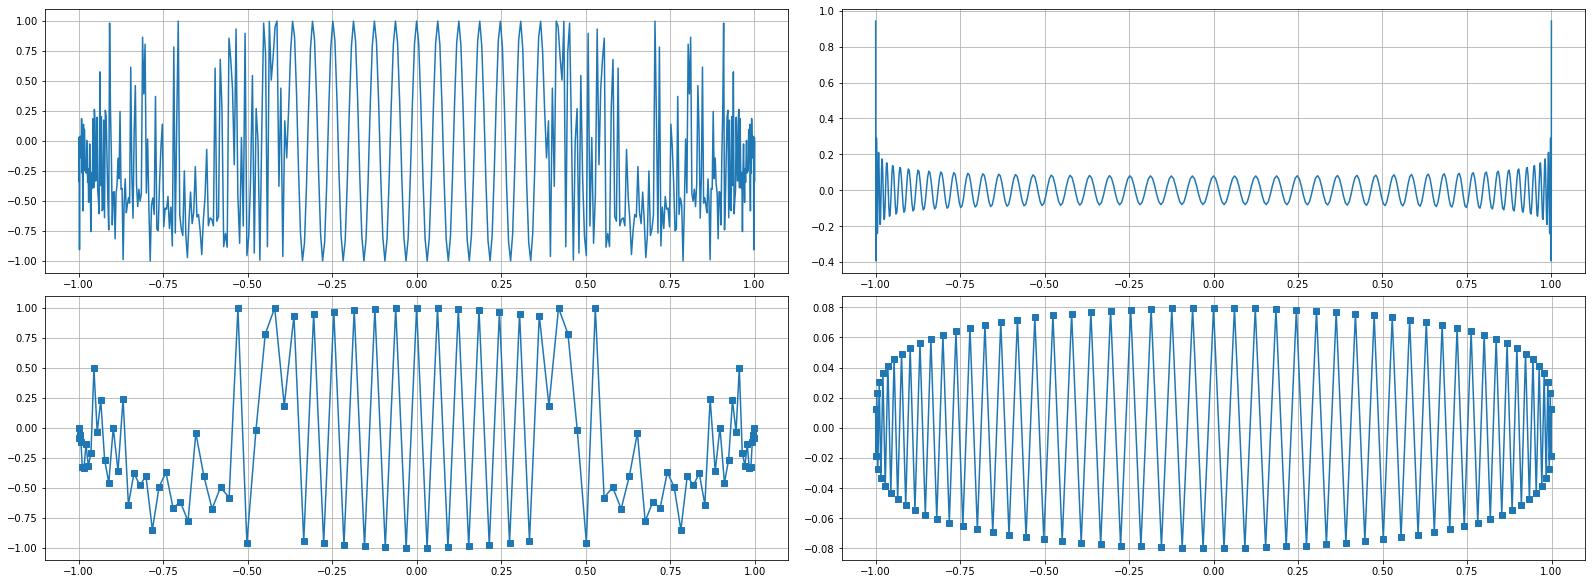

In [20]:
import matplotlib.pyplot as plt

lval = 100

f_integrand = sym.lambdify((xi,), single_mode_cos.subs({l_deg: lval}), modules=['numpy', 'scipy'])
xi_quad = specfun.roots_legendre(101)[0]
xi_show = specfun.roots_legendre(501)[0]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22, 8), layout='constrained')

ax = axes[0,0]
ax.plot(xi_show, f_integrand(xi_show))
ax.grid(which='both')

ax = axes[1,0]
ax.plot(xi_quad, f_integrand(xi_quad), 's-')
ax.grid(which='both')

ax = axes[0,1]
ax.plot(xi_show, specfun.eval_legendre(lval, xi_show))
ax.grid(which='both')

ax = axes[1,1]
ax.plot(xi_quad, specfun.eval_legendre(lval, xi_quad), 's-')
ax.grid(which='both')

plt.show()

---

## S1 background field (Luo & Jackson 2022, Waves I)

In [96]:
# S1 = (r**2*(5 - 3*r**2)*sym.cos(t), sym.S.Zero, sym.S.Zero)
S1_r = r*(5 - 3*r**2)
S1 = (S1_r*r*SH.Ynm(1, 0, theta, p).expand(func=True), sym.S.Zero, sym.S.Zero)
B_S1 = sph.curl(sph.curl(S1))
B_S1 = tuple(comp.simplify() for comp in B_S1)
display(*B_S1)

sqrt(3)*(5 - 3*r**2)*cos(\theta)/sqrt(pi)

sqrt(3)*(6*r**2 - 5)*sin(\theta)/sqrt(pi)

0

### Built-in S1 fields

In [97]:
from sympy.parsing.mathematica import parse_mathematica

In [98]:
parse_mathematica('1/5 Sqrt[(7 pi)/69] r(5 - 3r^2)')

sqrt(483)*sqrt(pi)*r*(5 - 3*r**2)/345

In [99]:
B_tmp = bg_fields.Background_S1()
display(*B_tmp.B0_val)

3*sqrt(3)*\gamma*s*z/sqrt(pi)

0

sqrt(3)*\gamma*(-6*s**2 - 3*z**2 + 5)/sqrt(pi)

Check if satisfies boundary condition

In [100]:
if_satisfy_dynamo_BC(S1_r, l_val=sym.S.One)

True

### Calculate radial and tangent field norm over the surface

In [101]:
Br_norm = int_sph_surf_axisym(B_S1[0]**2)
B_surf_norm = int_sph_surf_axisym(B_S1[1]**2 + B_S1[2]**2)
display(Br_norm, B_surf_norm)

16

8

In [110]:
(int_ball_axisym(B_S1[0]**2 + B_S1[1]**2)*sym.pi/75).evalf(7)

1.101053

### Calculate angle cosine norm over the surface

In [24]:
cos_angle = sym.simplify(B_S1[0]/sym.sqrt(B_S1[0]**2 + B_S1[1]**2 + B_S1[2]**2))

Analytical (for this it is possible)

In [11]:
cos_angle_2norm = sym.simplify(int_sph_surf_axisym(cos_angle**2)/(4*sym.pi))
cos_angle_2norm

-4*sqrt(3)*pi/27 + 4/3

In [12]:
cos_angle_2norm.evalf()

0.527200282562570

Numerical

In [13]:
cos_angle_2norm_num = quad_sph_surf_axisym(cos_angle**2)/(4*np.pi)
cos_angle_2norm_num

0.5272002825625681

----
## S2 background field (Luo & Jackson 2022, Waves II)

In [25]:
S2_r = r**2*(157 - 296*r**2 + 143*r**4)
S2 = (S2_r*r*SH.Ynm(2, 0, theta, p).expand(func=True), sym.S.Zero, sym.S.Zero)
B_S2 = sph.curl(sph.curl(S2))
B_S2 = tuple(comp.simplify() for comp in B_S2)
display(*B_S2)

3*sqrt(5)*r*((-143*r**4 + 296*r**2 - 157)*sin(\theta)**2 + (286*r**4 - 592*r**2 + 314)*cos(\theta)**2)/(2*sqrt(pi))

3*sqrt(5)*r*(-1001*r**4 + 1480*r**2 - 471)*sin(2*\theta)/(4*sqrt(pi))

0

In [26]:
B_s = B_S2[0]*sym.sin(theta) + B_S2[1]*sym.cos(theta)
display(B_s)

B_s.subs({r: sym.sqrt(s**2 + z**2), theta: sym.acos(z/sym.sqrt(s**2 + z**2))}).simplify()

3*sqrt(5)*r*((-143*r**4 + 296*r**2 - 157)*sin(\theta)**2 + (286*r**4 - 592*r**2 + 314)*cos(\theta)**2)*sin(\theta)/(2*sqrt(pi)) + 3*sqrt(5)*r*(-1001*r**4 + 1480*r**2 - 471)*sin(2*\theta)*cos(\theta)/(4*sqrt(pi))

3*sqrt(5)*s*(-143*s**4 - 858*s**2*z**2 + 296*s**2 - 715*z**4 + 888*z**2 - 157)/(2*sqrt(pi))

Check if satisfies boundary condition

In [15]:
if_satisfy_dynamo_BC(S2_r, l_val=sym.Integer(2))

True

### Calculate radial and tangent field norm over the surface

In [16]:
Br_norm = int_sph_surf_axisym(B_S2[0]**2)
B_surf_norm = int_sph_surf_axisym(B_S2[1]**2 + B_S2[2]**2)
display(Br_norm, B_surf_norm)

576

384

### Calculate angle cosine norm over the surface

In [17]:
cos_angle = sym.simplify(B_S2[0]/sym.sqrt(B_S2[0]**2 + B_S2[1]**2 + B_S2[2]**2))
cos_angle

-(2*(143*r**4 - 296*r**2 + 157)*sin(\theta)**2 - 2*(286*r**4 - 592*r**2 + 314)*cos(\theta)**2)/sqrt(4*(3*sin(\theta)**2 - 2)**2*(143*r**4 - 296*r**2 + 157)**2 + (1001*r**4 - 1480*r**2 + 471)**2*sin(2*\theta)**2)

Analytical: here the symbolic engine takes incredibly long time and didn't succeed

In [ ]:
cos_angle_2norm = sym.simplify(int_sph_surf_axisym(cos_angle**2)/(4*sym.pi))
cos_angle_2norm

Numerical:

In [18]:
cos_angle_2norm_num = quad_sph_surf_axisym(cos_angle**2)/(4*np.pi)
cos_angle_2norm_num

0.5243549428621038

---
## T2 background field

In [25]:
A1, A2, A3 = sym.symbols('A_1, A_2, A_3')

T2_r = r**2*(A_1 + A_2*r**2)
S2 = (S2_r*r*SH.Ynm(2, 0, theta, p).expand(func=True), sym.S.Zero, sym.S.Zero)
B_S2 = sph.curl(sph.curl(S2))
B_S2 = tuple(comp.simplify() for comp in B_S2)
display(*B_S2)

3*sqrt(5)*r*((-143*r**4 + 296*r**2 - 157)*sin(\theta)**2 + (286*r**4 - 592*r**2 + 314)*cos(\theta)**2)/(2*sqrt(pi))

3*sqrt(5)*r*(-1001*r**4 + 1480*r**2 - 471)*sin(2*\theta)/(4*sqrt(pi))

0

In [26]:
B_s = B_S2[0]*sym.sin(theta) + B_S2[1]*sym.cos(theta)
display(B_s)

B_s.subs({r: sym.sqrt(s**2 + z**2), theta: sym.acos(z/sym.sqrt(s**2 + z**2))}).simplify()

3*sqrt(5)*r*((-143*r**4 + 296*r**2 - 157)*sin(\theta)**2 + (286*r**4 - 592*r**2 + 314)*cos(\theta)**2)*sin(\theta)/(2*sqrt(pi)) + 3*sqrt(5)*r*(-1001*r**4 + 1480*r**2 - 471)*sin(2*\theta)*cos(\theta)/(4*sqrt(pi))

3*sqrt(5)*s*(-143*s**4 - 858*s**2*z**2 + 296*s**2 - 715*z**4 + 888*z**2 - 157)/(2*sqrt(pi))

Check if satisfies boundary condition

In [15]:
if_satisfy_dynamo_BC(S2_r, l_val=sym.Integer(2))

True

### Calculate radial and tangent field norm over the surface

In [16]:
Br_norm = int_sph_surf_axisym(B_S2[0]**2)
B_surf_norm = int_sph_surf_axisym(B_S2[1]**2 + B_S2[2]**2)
display(Br_norm, B_surf_norm)

576

384

---
## Linear combination of two fields

In [63]:
C1, C2 = sym.Integer(20), sym.S.One
B_combo = tuple(C1*B_S1[i] + C2*B_S2[i] for i in range(3))
display(*B_combo)

3*sqrt(5)*r*((-143*r**4 + 296*r**2 - 157)*sin(\theta)**2 + (286*r**4 - 592*r**2 + 314)*cos(\theta)**2)/(2*sqrt(pi)) + 20*sqrt(3)*(5 - 3*r**2)*cos(\theta)/sqrt(pi)

3*sqrt(5)*r*(-1001*r**4 + 1480*r**2 - 471)*sin(2*\theta)/(4*sqrt(pi)) + 20*sqrt(3)*(6*r**2 - 5)*sin(\theta)/sqrt(pi)

0

### Calculate radial and tangent field norm over the surface

In [64]:
Br_norm = int_sph_surf_axisym(B_combo[0]**2)
B_surf_norm = int_sph_surf_axisym(B_combo[1]**2 + B_combo[2]**2)
display(Br_norm, B_surf_norm)

6976

3584

### Calculate angle cosine norm over the surface

In [61]:
cos_angle = sym.simplify(B_combo[0]/sym.sqrt(B_combo[0]**2 + B_combo[1]**2 + B_combo[2]**2))
cos_angle

2*(-3*sqrt(5)*r*((-286*r**4 + 592*r**2 - 314)*cos(\theta)**2 + (143*r**4 - 296*r**2 + 157)*sin(\theta)**2) + 40*sqrt(3)*(3*r**2 - 5)*cos(\theta))/sqrt(4*(-3*sqrt(5)*r*(3*sin(\theta)**2 - 2)*(143*r**4 - 296*r**2 + 157) + 40*sqrt(3)*(3*r**2 - 5)*cos(\theta))**2 + (3*sqrt(5)*r*(1001*r**4 - 1480*r**2 + 471)*sin(2*\theta) + 80*sqrt(3)*(6*r**2 - 5)*sin(\theta))**2)

In [65]:
cos_angle = sym.simplify(B_combo[0]/sym.sqrt(B_combo[0]**2 + B_combo[1]**2 + B_combo[2]**2))
cos_angle

2*(-3*sqrt(5)*r*((-286*r**4 + 592*r**2 - 314)*cos(\theta)**2 + (143*r**4 - 296*r**2 + 157)*sin(\theta)**2) - 40*sqrt(3)*(3*r**2 - 5)*cos(\theta))/sqrt(4*(-3*sqrt(5)*r*(3*sin(\theta)**2 - 2)*(143*r**4 - 296*r**2 + 157) - 40*sqrt(3)*(3*r**2 - 5)*cos(\theta))**2 + (3*sqrt(5)*r*(1001*r**4 - 1480*r**2 + 471)*sin(2*\theta) - 80*sqrt(3)*(6*r**2 - 5)*sin(\theta))**2)

Analytical: here the symbolic engine takes incredibly long time and didn't succeed

In [ ]:
cos_angle_2norm = sym.simplify(int_sph_surf_axisym(cos_angle**2)/(4*sym.pi))
cos_angle_2norm

Numerical:

In [62]:
cos_angle_2norm_num = quad_sph_surf_axisym(cos_angle**2)/(4*np.pi)
cos_angle_2norm_num

0.5652810167796992

In [66]:
cos_angle_2norm_num = quad_sph_surf_axisym(cos_angle**2)/(4*np.pi)
cos_angle_2norm_num

0.5652810167796991

---
## Derive Galerkin basis

In [13]:
C, C1, C2, C3 = sym.symbols('C, C_1, C_2, C_3')

def worland(n, l):
    return r**l*sym.jacobi(n, -sym.S.Half, l - sym.S.Half, 2*r**2 - 1)

def recombined_galerkin_basis(basis, n1, n2, l_val, mode='Pol'):
    scalar = basis(n1, l_val).expand(func=True) + C*basis(n2, l_val).expand(func=True)
    bc_expr = insulate_BC_pol.subs({S_scalar: scalar}) if mode == 'Pol' else insulate_BC_tor.subs({T_scalar: scalar})
    bc_val = bc_expr.subs({l_deg: l_val, r: sym.S.One}).doit()
    C_val = sym.solve(bc_val, C)[0]
    galerkin_basis = scalar.subs({C: C_val})
    return galerkin_basis, C_val

### Poloidal Galerkin basis

Calculate the first five radial Galerkin bases for the poloidal scalar, at $l=2$

In [22]:
gbases = [recombined_galerkin_basis(worland, 0, n, 2)[0] for n in range(1, 5)]

Optional: trim constant coefficients

In [23]:
for i_basis, gbasis in enumerate(gbases):
    factors = sym.factor(gbasis).args
    gbases[i_basis] = sym.Mul(*[arg for arg in factors if not arg.is_number])

In [24]:
display(*[gbasis.factor() for gbasis in gbases])

r**2*(5*r**2 - 7)

r**2*(25*r**4 - 35*r**2 + 4)

r**2*(56*r**6 - 108*r**4 + 63*r**2 - 17)

r**2*(144*r**8 - 352*r**6 + 297*r**4 - 99*r**2 + 4)

Form magnetic fields from these basis, and calculate their energy integrals ($\int |\mathbf{B}|^2 \, dV$)

In [28]:
S_bases = [(gbasis*r*SH.Ynm(2, 0, theta, p).expand(func=True), sym.S.Zero, sym.S.Zero) for gbasis in gbases]
B_bases = [sph.curl(sph.curl(S_basis)) for S_basis in S_bases]
B_bases = [tuple(comp.simplify() for comp in B_tmp) for B_tmp in B_bases]
energy_integrals = [int_ball_axisym(B_tmp[0]**2 + B_tmp[1]**2 + B_tmp[2]**2) for B_tmp in B_bases]

In [29]:
display(*[B2_int for B2_int in energy_integrals])

416/3

383392/429

9592992/12155

109001376/146965

In [30]:
display(*[sym.sqrt(B2_int).evalf(7) for B2_int in energy_integrals])

11.77568

29.89461

28.09309

27.23385

Calculate maxima in the bulk

In [13]:
maxima = []

for B_basis in B_bases:
    var_r = (B_basis[0]**2 + B_basis[1]**2).subs({theta: 1*sym.pi/2})
    # var_r = (B_basis[0].subs({theta: 0})**2 + B_basis[1].subs({}))
    diff_r = sym.diff(var_r, r)
    # arg_extrema = list(sym.roots(diff_r, r).keys())
    arg_extrema = []
    if len(arg_extrema) <= 1:
        arg_extrema = sym.nroots(diff_r, n=15)
    arg_extrema = [arg for arg in arg_extrema if arg.as_real_imag()[1].equals(sym.S.Zero)]
    extrema = [var_r.subs({r: arg}).simplify() for arg in arg_extrema]
    i_max = np.argmax([abs(float(extremum.evalf(7))) for extremum in extrema])
    maxima.append(sym.sqrt(abs(extrema[i_max])))
    
display(*[maximum for maximum in maxima])

5*sqrt(3)/sqrt(pi)

5.34048999000404/sqrt(pi)

3*sqrt(3)/sqrt(pi)

24.0142190667377/sqrt(pi)

In [32]:
maxima = []

rg = np.linspace(0, 1, num=100)
tg = np.linspace(0, np.pi, num=100)
rr, tt = np.meshgrid(rg, tg)

for B_basis in B_bases:
    B2_f = sym.lambdify([r, t], (B_basis[0]**2 + B_basis[1]**2 + B_basis[2]**2), modules=['numpy', 'scipy'])
    B2_vals = B2_f(rr, tt)
    maxima.append(np.sqrt(np.max(B2_vals)))
    
maxima

### Toroidal Galerkin basis

Calculate the first five radial Galerkin bases for the toroidal scalar, at $l=2$

In [24]:
gbases = [recombined_galerkin_basis(worland, 0, n, 1, mode='Tor')[0] for n in range(1, 5)]

Optional: trim constant coefficients

In [25]:
for i_basis, gbasis in enumerate(gbases):
    factors = sym.factor(gbasis).args
    gbases[i_basis] = sym.Mul(*[arg for arg in factors if not arg.is_number])

In [26]:
display(*[gbasis.factor() for gbasis in gbases])

r*(r - 1)*(r + 1)

r*(r - 1)*(r + 1)*(2*r - 1)*(2*r + 1)

r*(r - 1)*(r + 1)*(2*r - 1)*(2*r + 1)*(2*r**2 - 1)

r*(r - 1)*(r + 1)*(2*r**2 - 1)*(4*r**2 - 2*r - 1)*(4*r**2 + 2*r - 1)

In [27]:
display(*[(gbasis/(r*(1 - r)*(1 + r))).simplify() for gbasis in gbases])

-1

1 - 4*r**2

-8*r**4 + 6*r**2 - 1

-32*r**6 + 40*r**4 - 14*r**2 + 1

Form magnetic fields from these basis, and calculate their energy integrals ($\int |\mathbf{B}|^2 \, dV$)

In [28]:
T_bases = [(gbasis*r*SH.Ynm(1, 0, theta, p).expand(func=True), sym.S.Zero, sym.S.Zero) for gbasis in gbases]
B_bases = [sph.curl(T_basis) for T_basis in T_bases]
B_bases = [tuple(comp.simplify() for comp in B_tmp) for B_tmp in B_bases]
energy_integrals = [int_ball_axisym(B_tmp[0]**2 + B_tmp[1]**2 + B_tmp[2]**2) for B_tmp in B_bases]

In [29]:
display(*[B_tmp[2] for B_tmp in B_bases])

sqrt(3)*r*(r**2 - 1)*sin(\theta)/(2*sqrt(pi))

sqrt(3)*r*(4*r**4 - 5*r**2 + 1)*sin(\theta)/(2*sqrt(pi))

sqrt(3)*r*(8*r**6 - 14*r**4 + 7*r**2 - 1)*sin(\theta)/(2*sqrt(pi))

sqrt(3)*r*(32*r**8 - 72*r**6 + 54*r**4 - 15*r**2 + 1)*sin(\theta)/(2*sqrt(pi))

In [30]:
display(*[B2_int for B2_int in energy_integrals])

16/315

976/15015

1424/109395

59632/4849845

In [31]:
display(*[sym.sqrt(B2_int.evalf(7)) for B2_int in energy_integrals])

0.2253745

0.2549542

0.1140923

0.1108858

Calculate maxima in the bulk

In [32]:
maxima = []

for B_basis in B_bases:
    var_r = B_basis[2].subs({theta: sym.pi/2})
    diff_r = sym.diff(var_r, r)
    arg_extrema = list(sym.roots(diff_r, r).keys())
    if len(arg_extrema) <= 1:
        arg_extrema = sym.nroots(diff_r, n=15)
    arg_extrema = [arg for arg in arg_extrema if arg.as_real_imag()[1].equals(sym.S.Zero)]
    extrema = [var_r.subs({r: arg}).simplify() for arg in arg_extrema]
    i_max = np.argmax([abs(float(extremum.evalf(7))) for extremum in extrema])
    maxima.append(abs(extrema[i_max]))
    
display(*[maximum.evalf(7) for maximum in maxima])

0.1880632

0.2217909

0.1162175

0.1185109

In [33]:
maxima[0]

1/(3*sqrt(pi))

In [48]:
maxima = []

rg = np.linspace(0, 1, num=100)
tg = np.linspace(0, np.pi, num=100)
rr, tt = np.meshgrid(rg, tg)

for B_basis in B_bases:
    B2_f = sym.lambdify([r, t], (B_basis[0]**2 + B_basis[1]**2 + B_basis[2]**2), modules=['numpy', 'scipy'])
    B2_vals = B2_f(rr, tt)
    maxima.append(np.sqrt(np.max(B2_vals)))
    
maxima

[0.2365138971747633,
 0.3106113124126478,
 0.8756932370827711,
 0.5622940863247085]

----
# Visualising the background field

In [2]:
import matplotlib.pyplot as plt
import os
from scipy import interpolate

Devise visualisation grid

In [3]:
r_grid = np.linspace(0, 1, num=50)
t_grid = np.linspace(0, np.pi, num=50)

r_mesh, t_mesh = np.meshgrid(r_grid, t_grid)
s_mesh, z_mesh = r_mesh*np.sin(t_mesh), r_mesh*np.cos(t_mesh)
p_mesh = 0*np.ones_like(s_mesh)

Vector visualisation grid

In [4]:
s_vec = np.linspace(0., 1., num=100)
z_vec = np.linspace(0., 1., num=100)
s_vec_mesh, z_vec_mesh = np.meshgrid(s_vec, z_vec)

Set up (axisymmetric) background field and evaluate

In [18]:
C1, C2 = sym.symbols('C_1, C_2')

# bg_comps = [bg_fields.Background_T1(), bg_fields.Background_S_l2_n1()]
bg_comps = [bg_fields.Background_S1(), bg_fields.Background_S2()]
for bg_comp in bg_comps:
    params = {bg_comp.params[i_key]: bg_comp.params_ref[0][i_key] for i_key in range(len(bg_comp.params))}
    bg_comp.subs(params, inplace=True)

bg = C1*bg_comps[0] + C2*bg_comps[1]
params = {C1: 1, C2: 1/8}

# bg = bg_fields.Background_T2()
# params = {bg.params[i_key]: bg.params_ref[0][i_key] for i_key in range(len(bg.params))}

bg_B = {
    's': sym.lambdify([core.s, core.p, core.z], bg.B0_val[0].subs(params), modules=['numpy', 'scipy'])(s_mesh, p_mesh, z_mesh)*np.ones_like(s_mesh),
    'p': sym.lambdify([core.s, core.p, core.z], bg.B0_val[1].subs(params), modules=['numpy', 'scipy'])(s_mesh, p_mesh, z_mesh)*np.ones_like(s_mesh),
    'z': sym.lambdify([core.s, core.p, core.z], bg.B0_val[2].subs(params), modules=['numpy', 'scipy'])(s_mesh, p_mesh, z_mesh)*np.ones_like(s_mesh)
}
bg_B['r'] = np.sin(t_mesh)*bg_B['s'] + np.cos(t_mesh)*bg_B['z']
bg_B['t'] = np.cos(t_mesh)*bg_B['s'] - np.sin(t_mesh)*bg_B['z']

In [14]:
bg.B0_val[0]

3*C_1*s*z/5 + 15*sqrt(2730)*C_2*s*(-143*s**4 - 858*s**2*z**2 + 296*s**2 - 715*z**4 + 888*z**2 - 157)/(5096*sqrt(pi))

Visualisation

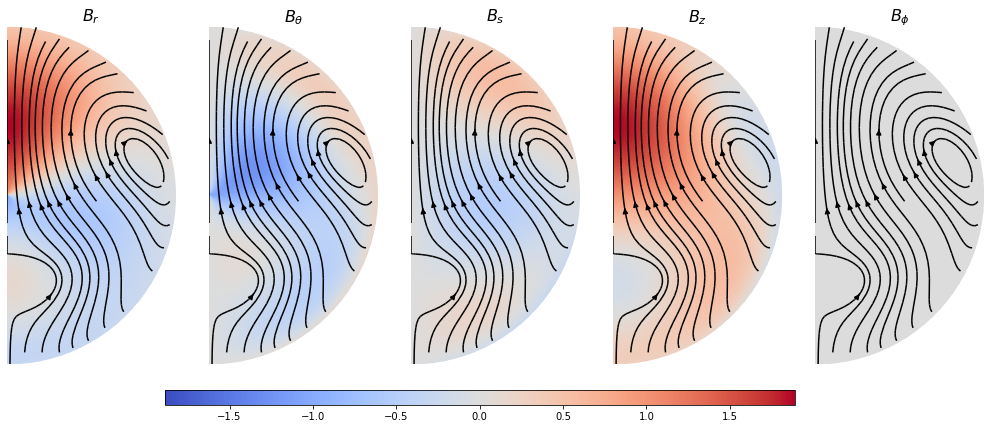

In [19]:
plot_fields = [['r', 't', 's', 'z', 'p'],]
plot_fnames = [[r"$B_r$", r"$B_\theta$", r"$B_s$", r"$B_z$", r"$B_\phi$"],]

save_name = './out/eigen/T1_SL2N1_std/bg_B_S1_T2_uscale'
save_name = None
override = False

uniform_cmap = True

symmetric_cmap = True
force_lines = True
normalizer = 1
weak_thresh = 1e-7

if force_lines:
    x_grid = np.linspace(0., 1., num=100)
    y_grid = np.linspace(-1., 1., num=200)
    XX, YY = np.meshgrid(x_grid, y_grid)
    Bx_grid = interpolate.griddata((s_mesh.flatten(), z_mesh.flatten()), bg_B['s'].flatten(), (XX, YY))
    By_grid = interpolate.griddata((s_mesh.flatten(), z_mesh.flatten()), bg_B['z'].flatten(), (XX, YY))

if uniform_cmap:
    climit = max([np.max(np.abs(bg_B[fname])) for fname in plot_fields[0] if fname is not None])

nrows, ncols = len(plot_fields), len(plot_fields[0])
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3.5, nrows*7))
axes = np.atleast_2d(axes)

for i_r in range(nrows):
    for i_c in range(ncols):
        
        fname = plot_fields[i_r][i_c]
        ax = axes[i_r][i_c]
        if fname is None:
            ax.remove()
            continue
        field_plot = bg_B[fname]/normalizer
        
        if uniform_cmap:
            cm = ax.pcolormesh(s_mesh, z_mesh, field_plot, shading='gouraud', cmap='coolwarm', vmin=-climit, vmax=+climit)
            # plt.colorbar(cm, ax=ax, orientation='horizontal')
            
        elif np.abs(np.real(field_plot)).max() > weak_thresh:

            if symmetric_cmap:
                climit = np.max(np.abs(field_plot))
                cm = ax.pcolormesh(s_mesh, z_mesh, field_plot, shading="gouraud", cmap="coolwarm", vmin=-climit, vmax=+climit)
                plt.colorbar(cm, ax=ax, orientation='horizontal')
            else:
                cm = ax.pcolormesh(s_mesh, z_mesh, field_plot, shading="gouraud", cmap="coolwarm")
                plt.colorbar(cm, ax=ax, orientation='horizontal')

        else:
            cm = ax.pcolormesh(s_mesh, z_mesh, field_plot, shading="gouraud", cmap="coolwarm", vmin=-weak_thresh, vmax=+weak_thresh)
            plt.colorbar(cm, ax=ax, orientation='horizontal')
        
        if force_lines:
            # ax.quiver(XX, YY, Bx_grid, By_grid, color='k', scale=10., scale_units='inches')
            ax.streamplot(XX, YY, Bx_grid, By_grid, color='k', density=1.0, minlength=.5)
        
        ax.set_title(plot_fnames[i_r][i_c], fontsize=16)
        ax.set_xlim([0, 1])
        ax.set_ylim([-1, 1])
        ax.set_aspect('equal', 'box')
        ax.axis("off")

if uniform_cmap:
    fig.subplots_adjust(bottom=0.05)
    cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
    fig.colorbar(cm, cax=cbar_ax, orientation='horizontal')
        
# plt.tight_layout()
if save_name is not None:
    if os.path.exists(save_name + '.png') and not override:
        print("File exists... aborting...")
    else:
        plt.savefig(save_name + '.png', format="png", dpi=150, bbox_inches="tight")

plt.show()